## Forecasting oil volume using various machine learning algorithms
by Jeremiah Chinyelugo

## BRIEF INTRODUCTION

This notebook will be divided into two parts. 
* In part 1, four (4) machine learning models will be used to predict the future oil production rate using a defined length of previous observations.
* In part 2 we will make alterations to the best performing model in part 1, and use it to determine how well we can predict future oil production rates (1 week) using a defined length of previous observations.

#### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

#### Loading the data

In [2]:
df = pd.read_excel('oil_production_data.xlsx')
df.head()

,oil (bbl/day)
0,1991.25000
1,1989.22500
2,1962.39375
3,1968.97500
4,1974.54375


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5035 entries, 0 to 5034
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   oil (bbl/day)  5035 non-null   float64
dtypes: float64(1)
memory usage: 39.5 KB


In [4]:
df.describe()

,oil (bbl/day)
count,5035.000000
mean,1660.668373
std,445.737635
min,670.612500
25%,1278.351366
50%,1621.550250
75%,2021.837572
max,2599.690708


#### Visualizing the data

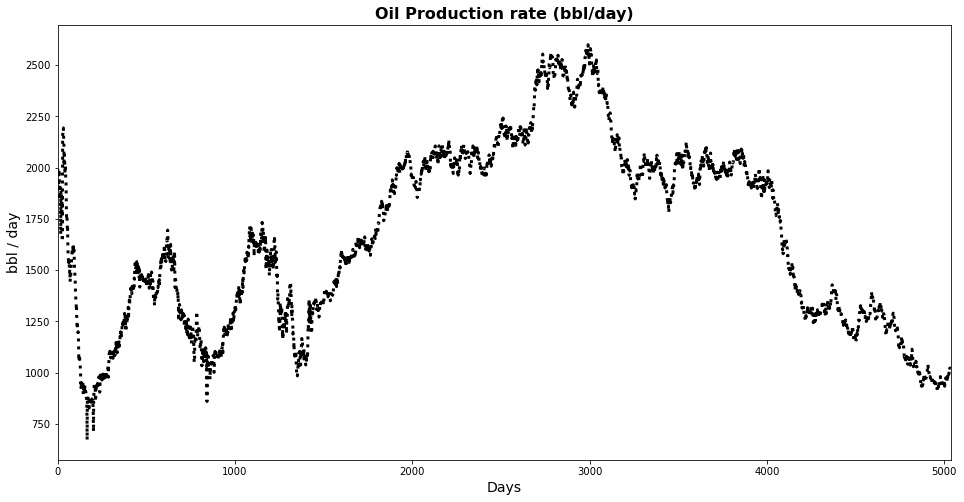

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['oil (bbl/day)'], 'k:', markersize=5, lw=3)
plt.axis([0, 5036, None, None])
plt.title('Oil Production rate (bbl/day)', fontsize=16, weight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('bbl / day', fontsize=14)
plt.show()

# PART 1
## Data Preprocessing

Before we train the model, there are several steps we need to go through. First, we need to separate our dataset into train and test sets. Because we have a time series data, there will be no need to shuffle the data becasue trends and patterns are important and shuffling the data destroys what pattern might have been noticed by the model when training. Our dataset has 5036 instances, i.e days, so the last 500 data points will be used as the test set while the rest will be used as the training.

In [6]:
# Separating then data into train and test

X_train, X_test = df[:-500].values.tolist(), df[-500:].values.tolist()

When working on any machine learning project, scaling is arguably one of the most important steps in data preprocessing. Scaling works by transforming all our data to values within the same range. This helps reduce the effects of large numbers when training our model. 

We are going to be applying standardization to our data. Standardization is done by subtracting the mean and dividing by the standard deviation for each variable

Z = $\frac{value\space -\space mean}{standard\space deviation}$

In [7]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The next step is to create a function that divides our datasets in inputs and outputs.

This function will create a sequence of previous observations as the input using a specific `window_length`, and a future value as the output. 

In [8]:
# Function for splitting sequences

def split_sequence(sequence, window_length):
    X, y = [], []
    for i in range(len(sequence)):
        end_idx = window_length + i
        if end_idx >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
            
    return np.array(X), np.array(y)

## Creating and Training the model
In this section, four(4) machine learning models will be built and trained on the preprocessed provided training data. Each model will be evaluated on three(3) metrics; mean absolute error, mean squared error and mean absolute percentage error. 
The learning curve, consisting of each model's training and validation loss will be plotted in addition to the comparison of model predictions and test targets.

**Note:** For each model, the training set will consist of the previous 60 occurrences as the predictors and the following value as the target. The range is called the window length, and adjusting it can alter model performance for good or bad. I will be using the same window length for all models in order to have the same basis for comparison, but in reality getting the best performance from a model will involve tuning the window length of each model. <br/>
Due to the stochastic nature of machine learning models, i will also use a common random seed (42) when training these models in order to have reproducibility.

### 1. Artificial Neural Network (ANN)

In [101]:
# processing the data in the required format

X_train, y_train = split_sequence(X_train_scaled, window_length=60)
X_test, y_test = split_sequence(X_test_scaled, window_length=60)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

print(X_train.shape, y_train.shape)

(4475, 60) (4475, 1)


In [10]:
# Creating and compiling the model

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

ann_model = keras.models.Sequential([
    keras.layers.Dense(50, activation='selu', input_shape=X_train.shape[1:]),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(30, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(1)
])

# creating a callback that stops trainin when val loss tops increasing after 10 epochs
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10)

# compiling the model using mean_squared_error as the loss function and adam as the optimizer
ann_model.compile(loss='mse', optimizer='adam')

In [11]:
# training the model
ann_history = ann_model.fit(X_train, y_train, epochs=200, validation_split=0.2, 
                           callbacks=EarlyStopping_cb)

Epoch 1/200
112/112 [==============================] - 1s 2ms/step - loss: 0.5252 - val_loss: 0.0615
Epoch 2/200
112/112 [==============================] - 0s 1ms/step - loss: 0.1540 - val_loss: 0.0518
Epoch 3/200
112/112 [==============================] - 0s 1ms/step - loss: 0.1026 - val_loss: 0.0394
Epoch 4/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0839 - val_loss: 0.0561
Epoch 5/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0757 - val_loss: 0.0285
Epoch 6/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0130
Epoch 7/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0216
Epoch 8/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0523 - val_loss: 0.0180
Epoch 9/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0474 - val_loss: 0.0066
Epoch 10/200
112/112 [==============================] - 0s 1ms/step - loss: 0.0453 - val_lo

In [91]:
# predicting the test set and inverse scaling the predictions and test targets

actual_targets = scaler.inverse_transform(y_test)
ann_predictions = scaler.inverse_transform(ann_model.predict(X_test, verbose=0))

In [92]:
# evaluating the model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

ann_mse = mean_squared_error(actual_targets, ann_predictions)
ann_mae = mean_absolute_error(actual_targets, ann_predictions)
ann_mape = mean_absolute_percentage_error(actual_targets, ann_predictions)

In [93]:
print(f"ANN MSE: {ann_mse:,.2f}")
print(f"ANN MAE: {ann_mae:,.2f}")
print(f"ANN MAPE: {ann_mape:,.2%}")

ANN MSE: 3,742.04
ANN MAE: 53.71
ANN MAPE: 5.26%


In [94]:
# Creating the training history dataframe

ann_df = pd.DataFrame(ann_history.history)
ann_df.head()

,loss,val_loss
0,0.525223,0.061496
1,0.154028,0.051845
2,0.102558,0.039359
3,0.083906,0.056100
4,0.075743,0.028480


##### Learning Curve
To aid the comparison of all model performance, the training and validation loss (mse) will be constrained within a fixed range.

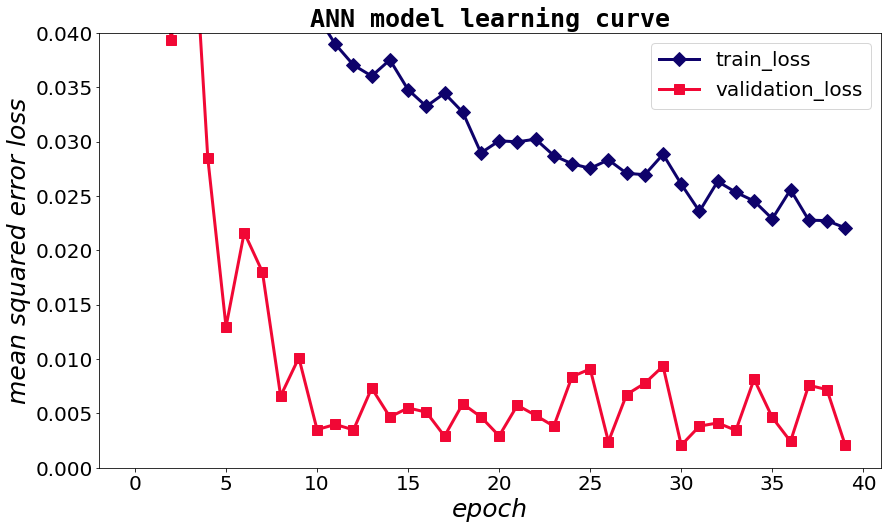

In [95]:
plt.figure(figsize=(14,8))

plt.plot(np.arange(len(ann_df)-1), ann_df['loss'][1:], label='train_loss', color='#0E026B', marker='D', lw=3, markersize=10)
plt.plot(np.arange(len(ann_df)-1), ann_df['val_loss'][:-1], label='validation_loss', color='#F10835', marker='s', lw=3, markersize=10)
plt.title('ANN model learning curve', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.xlabel('epoch', style='italic', fontsize=25)
plt.ylabel('mean squared error loss', style='italic', fontsize=25)
plt.ylim([0,0.04])
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### Comparing model predictions to actual data

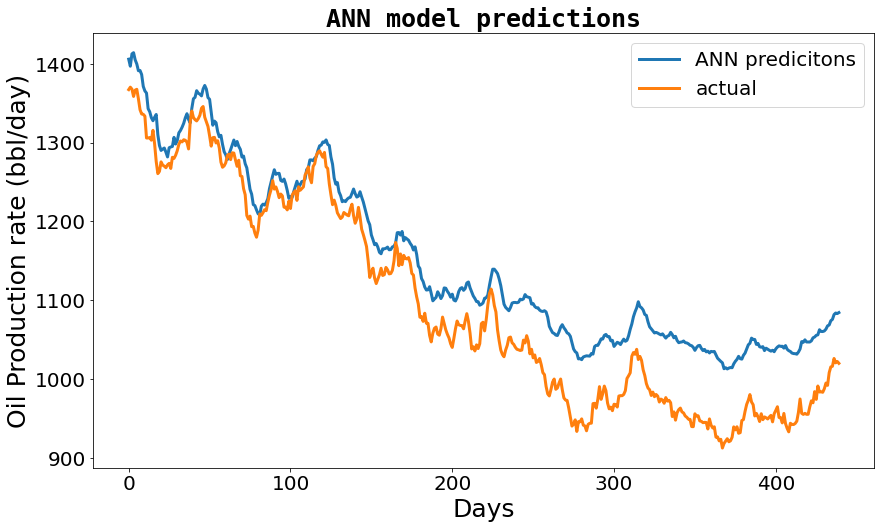

In [106]:
plt.figure(figsize=(14,8))

plt.plot(ann_predictions, label='ANN predicitons', lw=3)
plt.plot(actual_targets, label='actual', lw=3)
plt.title("ANN model predictions", fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### 2. Long-Short-Term-Memory (LSTM)

In [28]:
# processing the data in the required format

X_train, y_train = split_sequence(X_train_scaled, window_length=60)
X_test, y_test = split_sequence(X_test_scaled, window_length=60)

print(X_train.shape, y_train.shape)

(4475, 60, 1) (4475, 1)


In [29]:
# Creating and compiling the model

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(50, activation='selu', input_shape=[None, 1], return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.LSTM(30, activation='selu', return_sequences=True),
    keras.layers.LSTM(30, activation='selu', return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(20, activation='selu'),
    keras.layers.Dense(1)
])

# creating a callback that stops trainin when val loss tops increasing after 10 epochs
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10)

# compiling the model using mean_squared_error as the loss function and adam as the optimizer
lstm_model.compile(loss='mse', optimizer='adam')

In [30]:
# training the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=200, validation_split=0.2, 
                           callbacks=EarlyStopping_cb)

Epoch 1/200
112/112 [==============================] - 9s 48ms/step - loss: 0.0864 - val_loss: 0.0191
Epoch 2/200
112/112 [==============================] - 5s 43ms/step - loss: 0.0268 - val_loss: 0.0111
Epoch 3/200
112/112 [==============================] - 5s 44ms/step - loss: 0.0206 - val_loss: 0.0071
Epoch 4/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0173 - val_loss: 0.0098
Epoch 5/200
112/112 [==============================] - 5s 43ms/step - loss: 0.0150 - val_loss: 0.0067
Epoch 6/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 7/200
112/112 [==============================] - 5s 43ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 8/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0127 - val_loss: 0.0052
Epoch 9/200
112/112 [==============================] - 5s 43ms/step - loss: 0.0118 - val_loss: 0.0074
Epoch 10/200
112/112 [==============================] - 5s 43ms/step - loss: 0.011

In [31]:
# predicting the test set and inverse scaling the predicitons and test targets

actual_targets = scaler.inverse_transform(y_test)
lstm_predictions = scaler.inverse_transform(lstm_model.predict(X_test, verbose=0))

In [32]:
# evaluating the model

lstm_mse = mean_squared_error(actual_targets, lstm_predictions)
lstm_mae = mean_absolute_error(actual_targets, lstm_predictions)
lstm_mape = mean_absolute_percentage_error(actual_targets, lstm_predictions)

In [33]:
print(f"LSTM MSE: {lstm_mse:,.2f}")
print(f"LSTM MAE: {lstm_mae:,.2f}")
print(f"LSTM MAPE: {lstm_mape:,.2%}")

LSTM MSE: 1,394.13
LSTM MAE: 35.47
LSTM MAPE: 3.30%


In [34]:
# Creating the training history dataframe

lstm_df = pd.DataFrame(lstm_history.history)
lstm_df.head()

,loss,val_loss
0,0.086427,0.019143
1,0.026761,0.011138
2,0.020625,0.007144
3,0.017289,0.009758
4,0.014984,0.006675


##### Learning Curve

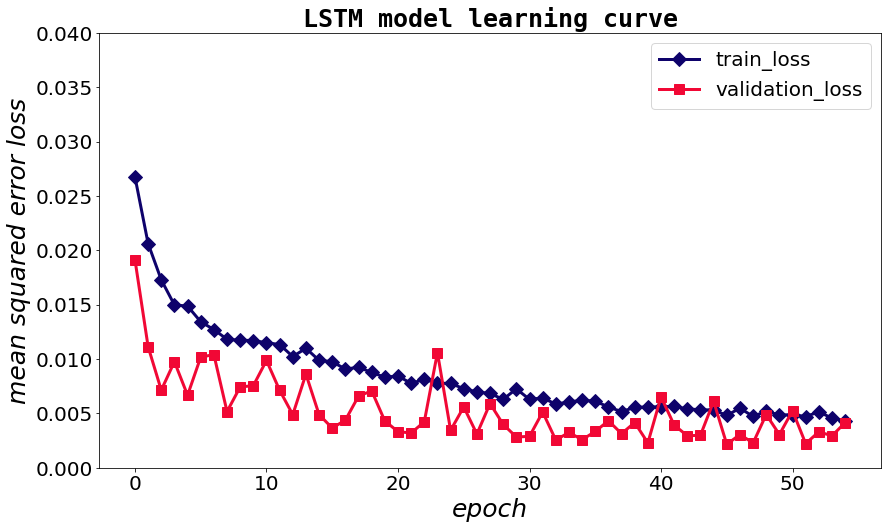

In [79]:
plt.figure(figsize=(14,8))

plt.plot(np.arange(len(lstm_df)-1), lstm_df['loss'][1:], label='train_loss', color='#0E026B', marker='D', lw=3, markersize=10)
plt.plot(np.arange(len(lstm_df)-1), lstm_df['val_loss'][:-1], label='validation_loss', color='#F10835', marker='s', lw=3, markersize=10)
plt.title('LSTM model learning curve', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.xlabel('epoch', style='italic', fontsize=25)
plt.ylabel('mean squared error loss', style='italic', fontsize=25)
plt.ylim([0,0.04])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Comparing model predictions to actual data

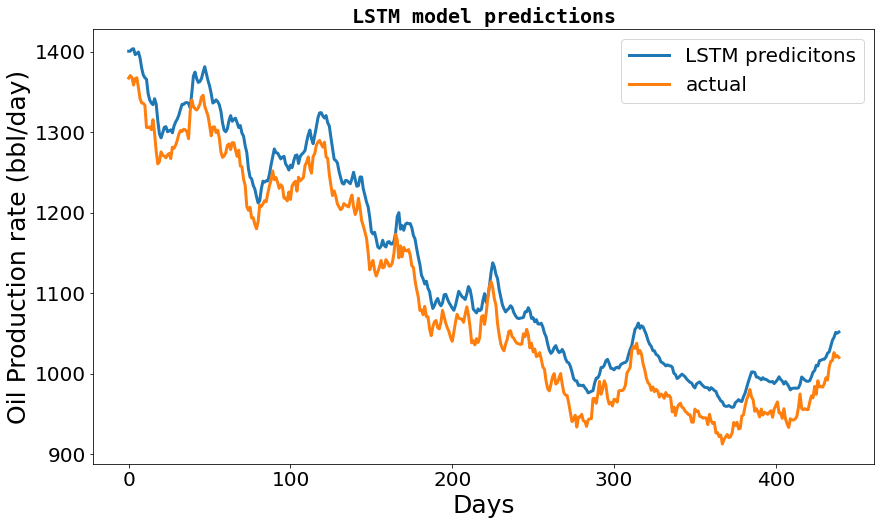

In [105]:
plt.figure(figsize=(14,8))

plt.plot(lstm_predictions, label='LSTM predicitons', lw=3)
plt.plot(actual_targets, label='actual', lw=3)
plt.title("LSTM model predictions", fontfamily='monospace', fontsize=20, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### 3. Gated-Rectified-Unit

In [37]:
# preprocessing the data in the required format

X_train, y_train = split_sequence(X_train_scaled, window_length=60)
X_test, y_test = split_sequence(X_test_scaled, window_length=60)

print(X_train.shape, y_train.shape)

(4475, 60, 1) (4475, 1)


In [38]:
# Creating and compiling the model

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

gru_model = keras.models.Sequential([
    keras.layers.GRU(50, activation='selu', input_shape=[None, 1], return_sequences=True),
    keras.layers.Dropout(0.4),
    keras.layers.GRU(30, activation='selu', return_sequences=True),
    keras.layers.GRU(30, activation='selu', return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(20, activation='selu'),
    keras.layers.Dense(1)
])

# creating a callback that stops trainin when val loss tops increasing after 10 epochs
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10)

# compiling the model using mean_squared_error as the loss function and adam as the optimizer
gru_model.compile(loss='mse', optimizer='adam')

In [39]:
# training the model
gru_history = gru_model.fit(X_train, y_train, epochs=200, validation_split=0.2, 
                           callbacks=EarlyStopping_cb)

Epoch 1/200
112/112 [==============================] - 10s 49ms/step - loss: 0.0894 - val_loss: 0.0054
Epoch 2/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0198 - val_loss: 0.0048
Epoch 3/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0154 - val_loss: 0.0040
Epoch 4/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0133 - val_loss: 0.0037
Epoch 5/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 6/200
112/112 [==============================] - 5s 43ms/step - loss: 0.0117 - val_loss: 0.0050
Epoch 7/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 8/200
112/112 [==============================] - 5s 41ms/step - loss: 0.0093 - val_loss: 0.0027
Epoch 9/200
112/112 [==============================] - 5s 42ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 10/200
112/112 [==============================] - 5s 41ms/step - loss: 0.00

In [40]:
# predicting the test set and inverse scaling the predicitons and test targets

actual_targets = scaler.inverse_transform(y_test)
gru_predictions = scaler.inverse_transform(gru_model.predict(X_test, verbose=0))

In [41]:
# evaluating the model

gru_mse = mean_squared_error(actual_targets, gru_predictions)
gru_mae = mean_absolute_error(actual_targets, gru_predictions)
gru_mape = mean_absolute_percentage_error(actual_targets, gru_predictions)

In [42]:
print(f"GRU MSE: {gru_mse:,.2f}")
print(f"GRU MAE: {gru_mae:,.2f}")
print(f"GRU MAPE: {gru_mape:,.2%}")

GRU MSE: 344.22
GRU MAE: 15.07
GRU MAPE: 1.33%


In [43]:
print(f"GRU MSE: {gru_mse:,.2f}")
print(f"GRU MAE: {gru_mae:,.2f}")
print(f"GRU MAPE: {gru_mape:,.2%}")

GRU MSE: 344.22
GRU MAE: 15.07
GRU MAPE: 1.33%


In [44]:
# Creating the gru history dataframe

gru_df = pd.DataFrame(gru_history.history)
gru_df.head()

,loss,val_loss
0,0.089366,0.005414
1,0.019775,0.004818
2,0.015366,0.004049
3,0.013276,0.003683
4,0.011504,0.005636


##### Learning Curve

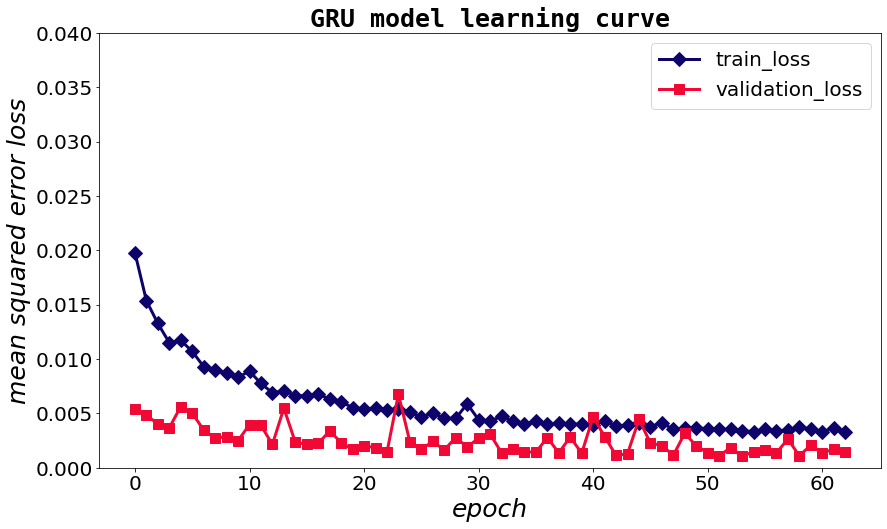

In [80]:
plt.figure(figsize=(14,8))

plt.plot(np.arange(len(gru_df)-1), gru_df['loss'][1:], label='train_loss', color='#0E026B', marker='D', lw=3, markersize=10)
plt.plot(np.arange(len(gru_df)-1), gru_df['val_loss'][:-1], label='validation_loss', color='#F10835', marker='s', lw=3, markersize=10)
plt.title('GRU model learning curve', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.xlabel('epoch', style='italic', fontsize=25)
plt.ylabel('mean squared error loss', style='italic', fontsize=25)
plt.ylim([0,0.04])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Comparing model predictions to actual data

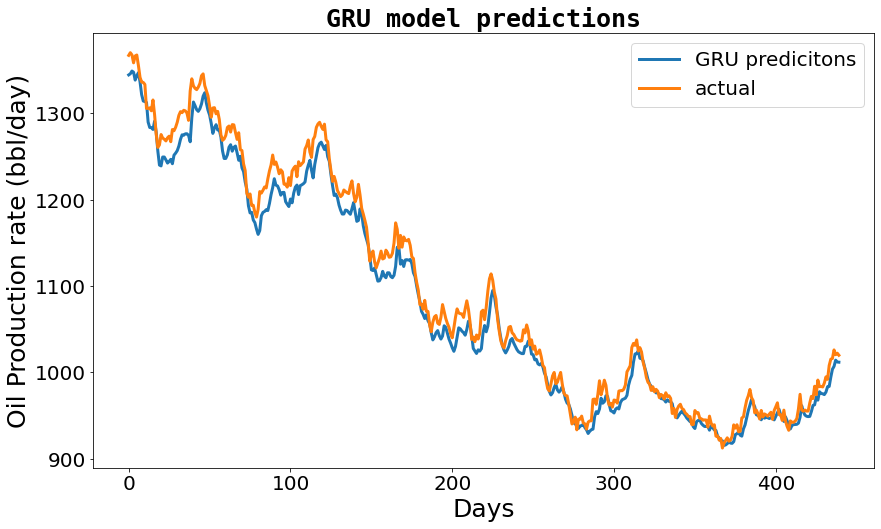

In [110]:
plt.figure(figsize=(14,8))

plt.plot(gru_predictions, label='GRU predicitons', lw=3)
plt.plot(actual_targets, label='actual',lw=3)
plt.title("GRU model predictions", fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## CONV-LSTM

In [111]:
# preprocessing the data in the required format

X_train_split, y_train = split_sequence(X_train_scaled, window_length=60)
X_test_split, y_test = split_sequence(X_test_scaled, window_length=60)

n_seq = 6
n_steps = 10
n_features = 1

X_train = X_train_split.reshape(X_train_split.shape[0], n_seq, n_steps, n_features)
X_test = X_test_split.reshape(X_test_split.shape[0], n_seq, n_steps, n_features)

In [48]:
X_train.shape, y_train.shape

((4475, 6, 10, 1), (4475, 1))

In [49]:
# Creating the CONV-LSTM model

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

conv_lstm_model = keras.models.Sequential([
    keras.layers.TimeDistributed(keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=[None, n_steps, n_features]),
    keras.layers.TimeDistributed(keras.layers.MaxPool1D(pool_size=2)),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(50, activation='relu'),
    keras.layers.Dense(1)
])

# creating a callback that stops trainin when val loss tops increasing after 10 epochs
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10)

# compiling the model using mean_squared_error as the loss function and adam as the optimizer
conv_lstm_model.compile(loss='mse', optimizer='adam')

conv_lstm_history = conv_lstm_model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=EarlyStopping_cb)

Epoch 1/200
112/112 [==============================] - 2s 6ms/step - loss: 0.0749 - val_loss: 0.0074
Epoch 2/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 3/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 4/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 5/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 6/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 7/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 9/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 10/200
112/112 [==============================] - 0s 4ms/step - loss: 0.0032 - val_lo

In [50]:
# predicting the test set and inverse scaling the predicitons and test targets

actual_targets = scaler.inverse_transform(y_test)
conv_lstm_predictions = scaler.inverse_transform(conv_lstm_model.predict(X_test, verbose=0))

In [51]:
# evaluating the model

conv_lstm_mse = mean_squared_error(actual_targets, conv_lstm_predictions)
conv_lstm_mae = mean_absolute_error(actual_targets, conv_lstm_predictions)
conv_lstm_mape = mean_absolute_percentage_error(actual_targets, conv_lstm_predictions)

In [52]:
print(f"CONV-LSTM MSE: {conv_lstm_mse:,.2f}")
print(f"CONV-LSTM MAE: {conv_lstm_mae:,.2f}")
print(f"CONV-LSTM MAPE: {conv_lstm_mape:,.2%}")

CONV-LSTM MSE: 236.52
CONV-LSTM MAE: 12.93
CONV-LSTM MAPE: 1.20%


In [53]:
# Creating the dataframe

conv_lstm_df = pd.DataFrame(conv_lstm_history.history)
conv_lstm_df.head()

,loss,val_loss
0,0.074851,0.007450
1,0.010166,0.004601
2,0.006198,0.003344
3,0.004720,0.002595
4,0.003989,0.002862


##### Learning Curve

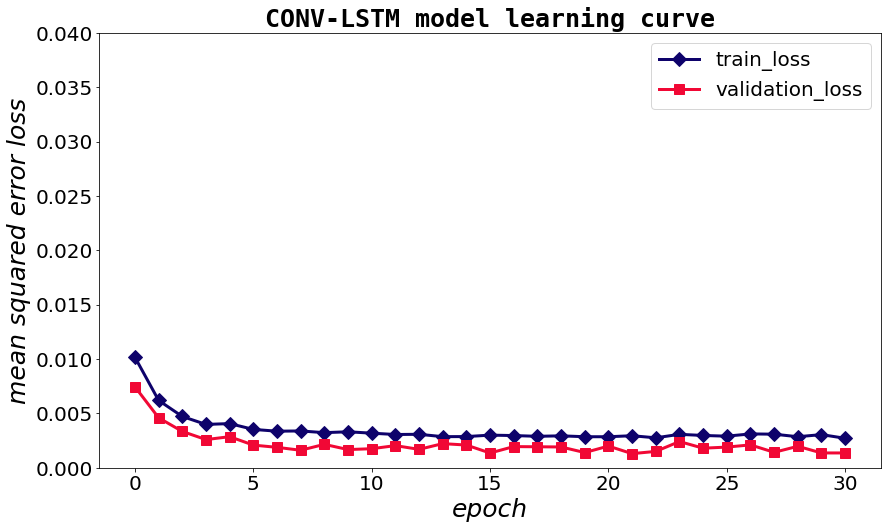

In [69]:
plt.figure(figsize=(14,8))

plt.plot(np.arange(len(conv_lstm_df)-1), conv_lstm_df['loss'][1:], label='train_loss', color='#0E026B', marker='D', lw=3, markersize=10)
plt.plot(np.arange(len(conv_lstm_df)-1), conv_lstm_df['val_loss'][:-1], label='validation_loss', color='#F10835', marker='s', lw=3, markersize=10)
plt.title('CONV-LSTM model learning curve', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.xlabel('epoch', style='italic', fontsize=25)
plt.ylabel('mean squared error loss', style='italic', fontsize=25)
plt.ylim([0,0.04])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Comparing model predictions to actual data

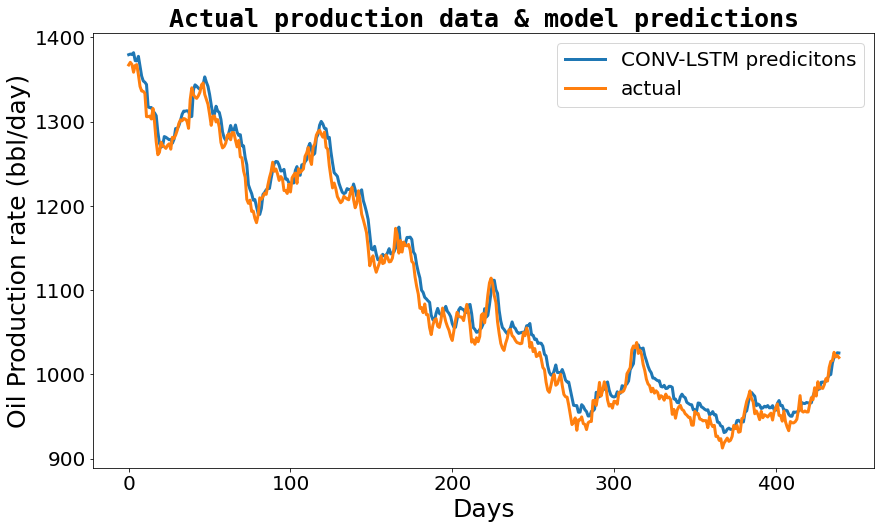

In [109]:
plt.figure(figsize=(14,8))

plt.plot(conv_lstm_predictions, label='CONV-LSTM predicitons', lw=3)
plt.plot(actual_targets, label='actual', lw=3)
plt.title("Actual production data & model predictions", fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

To fully understand how well our model performed, we are going to plot a section of the training data with the actual test targets and our model predictions

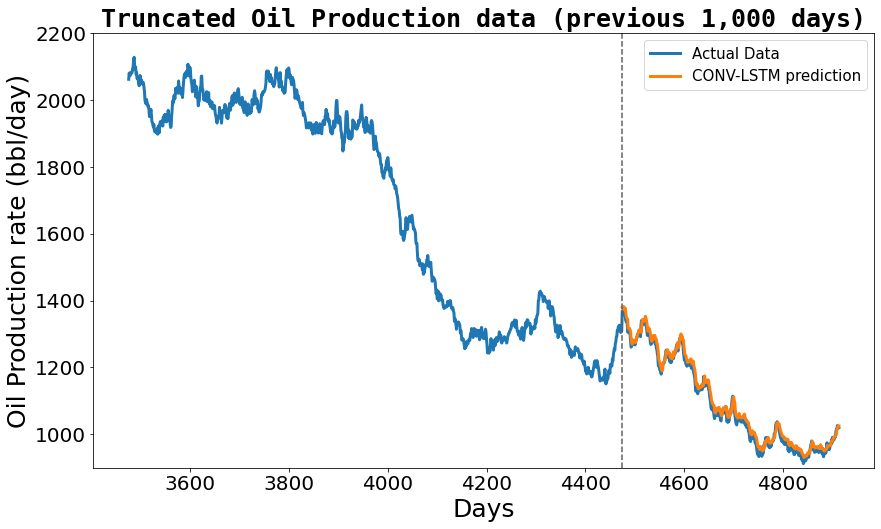

In [122]:
train_extract = scaler.inverse_transform(y_train[-1000:])

plt.figure(figsize=(14,8))

plt.plot(np.arange(3475,4915), np.vstack((train_extract, actual_targets)), label = 'Actual Data', lw=3)
plt.plot(np.arange(4475,4915), conv_lstm_predictions, label = 'CONV-LSTM prediction', lw=3)
plt.plot([4475,4475], [900,2200], color='#645F5C', linestyle='--')
plt.ylim([900, 2200])
plt.title('Truncated Oil Production data (previous 1,000 days)', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

## Results

### Model Evaluation

In [57]:
metrics_df = pd.DataFrame({
    'Metrics':['MSE', 'RMSE', 'MAE'],
    'ANN':[ann_mse, np.sqrt(ann_mse), ann_mae],
    'LSTM':[lstm_mse, np.sqrt(lstm_mse), lstm_mae],
    'GRU':[gru_mse, np.sqrt(gru_mse), gru_mae],
    'CONV-LSTM':[conv_lstm_mse, np.sqrt(conv_lstm_mse), conv_lstm_mae]
})

metrics_df = metrics_df.style.format({
    'ANN':"{:,.2f}",
    'LSTM':"{:,.2f}",
    'GRU':"{:,.2f}",
    'CONV-LSTM':"{:,.2f}",
})

metrics_df

,Metrics,ANN,LSTM,GRU,CONV-LSTM
0,MSE,"3,742.04","1,394.13",344.22,236.52
1,RMSE,61.17,37.34,18.55,15.38
2,MAE,53.71,35.47,15.07,12.93


### Visualizing all model predicitons

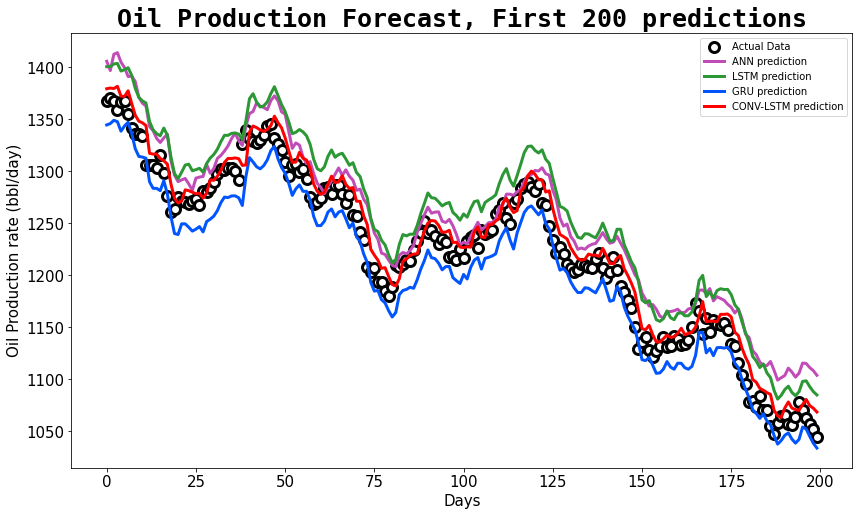

In [119]:
sample = 200

plt.figure(figsize=(14,8))

plt.scatter(x=np.arange(sample), y=actual_targets[:sample], label = 'Actual Data', 
         color='#FFFFFF', s=100, ec='k', lw=3)
plt.plot(np.arange(sample), ann_predictions[:sample], label = 'ANN prediction', color='#C14CB8', lw=3)
plt.plot(np.arange(sample), lstm_predictions[:sample], label = 'LSTM prediction', color='#2C9735', lw=3)
plt.plot(np.arange(sample), gru_predictions[:sample], label = 'GRU prediction', color='#0055FF', lw=3)
plt.plot(np.arange(sample), conv_lstm_predictions[:sample], label = 'CONV-LSTM prediction', color='#FF0000', lw=3)
plt.title(f'Oil Production Forecast, First {sample} predictions', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=10)
plt.show()

# PART 2

In part 1 we created four(4) models that can predict the future oil production rate based on the previous 60 days (2 months). The CONV-LSTM model had the best performance of all models, and in part 2, we will use the same model architecture with slight adjustment to the target size to create a model that can predict the oil production rate 1 week ahead (7 days) based on the previous 60 days.

## Data Preprocessing

In [59]:
# Separating then data into train and test

X_train, X_test = df[:-500].values.tolist(), df[-500:].values.tolist()

In [60]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The next step is to create a function that divides our datasets in inputs and outputs.

The function created in part 1 will be reused with some minor additions and alterations to the underlying code. The `target_step` paramter will be added to manage the target size, in this case, 7 instead of 1.

In [61]:
def split_sequence_2(sequence, window_length, target_step):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = window_length+i
        if end_ix+target_step >= len(sequence):
            break
        a = sequence[i:end_ix]
        b = sequence[end_ix:end_ix+target_step]
        X.append(a) 
        y.append(b)
    return np.array(X), np.array(y)

## CHANGE

Once we have obtained our sequence and target, thh next step will be to reshape our sequence like we did in part 1. However, this time around we will be reshaping our targets as well to ensure we have the right shape needed by the model.

**N.B**: Hours was spent on hyperparamter tuning like window_length selection, random_seed number and model architecture had already been done prior to this final notebook. So we will be using the paramters that gave me the best performance

We will retain the window length of 60, i.e (60 previous sequences per future observation) because i had already tried various window lengths and found 60 to give the best performance.

In [128]:
# further preprocessing

X_train_split, y_train_split = split_sequence_2(X_train_scaled, window_length=90, target_step=14)
X_test_split, y_test_split = split_sequence_2(X_test_scaled, window_length=90, target_step=14)

n_seq = 9
n_steps = 10
n_features = 1

X_train = X_train_split.reshape(X_train_split.shape[0], n_seq, n_steps, n_features)
X_test = X_test_split.reshape(X_test_split.shape[0], n_seq, n_steps, n_features)

y_train = y_train_split.reshape(y_train_split.shape[0], y_train_split.shape[1])
y_test = y_test_split.reshape(y_test_split.shape[0], y_train_split.shape[1])

In [129]:
X_train.shape, y_train.shape

((4431, 9, 10, 1), (4431, 14))

###### Creating the CONV-LSTM model

In [130]:
# Creating the CONV-LSTM model

keras.backend.clear_session()

np.random.seed(35)
tf.random.set_seed(35)

conv_lstm_model2 = keras.models.Sequential([
    keras.layers.TimeDistributed(keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=[None, n_steps, n_features]),
    keras.layers.TimeDistributed(keras.layers.MaxPool1D(pool_size=2)),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(50, activation='relu'),
    keras.layers.Dense(14)
])

EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10)
conv_lstm_model2.compile(loss='mse', optimizer='adam')

conv_lstm_history2 = conv_lstm_model2.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=EarlyStopping_cb)

Epoch 1/200
111/111 [==============================] - 2s 7ms/step - loss: 0.1752 - val_loss: 0.0219
Epoch 2/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0149
Epoch 3/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 4/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0105
Epoch 5/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0101
Epoch 6/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0095
Epoch 7/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 8/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0084
Epoch 9/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 10/200
111/111 [==============================] - 1s 5ms/step - loss: 0.0129 - val_lo

In [131]:
actual_targets = scaler.inverse_transform(y_test)
conv_lstm_predictions2 = scaler.inverse_transform(conv_lstm_model2.predict(X_test, verbose=0))

In [132]:
def process_predictions(pred):
    processed_data = []
    for i in range(pred.shape[0]):
        if i < 1:
            processed_data.extend(pred[i])
        else:
            temp1 = processed_data[i:]
            temp2 = pred[i][:-1]
            last_val = pred[i][-1]

            final_temp = (temp1 + temp2)/2
            processed_data[i:] = final_temp
            processed_data.append(last_val)
    return np.array(processed_data)

In [133]:
conv_lstm_predictions2 = process_predictions(conv_lstm_predictions2)
actual_targets = process_predictions(actual_targets)

In [134]:
# evaluating the model

conv_lstm_mse2 = mean_squared_error(actual_targets, conv_lstm_predictions2)
conv_lstm_mae2 = mean_absolute_error(actual_targets, conv_lstm_predictions2)
conv_lstm_mape2 = mean_absolute_percentage_error(actual_targets, conv_lstm_predictions2)

In [135]:
print(f"CONV-LSTM MSE: {conv_lstm_mse2:,.2f}")
print(f"CONV-LSTM MAE: {conv_lstm_mae2:,.2f}")
print(f"CONV-LSTM MAPE: {conv_lstm_mape2:,.2%}")

CONV-LSTM MSE: 244.11
CONV-LSTM MAE: 12.12
CONV-LSTM MAPE: 1.12%


In [136]:
# Creating the dataframe

conv_lstm_df2 = pd.DataFrame(conv_lstm_history2.history)
conv_lstm_df2.head()

,loss,val_loss
0,0.175199,0.021877
1,0.023259,0.014897
2,0.016576,0.011358
3,0.014739,0.010456
4,0.014504,0.010116


##### Learning Curve

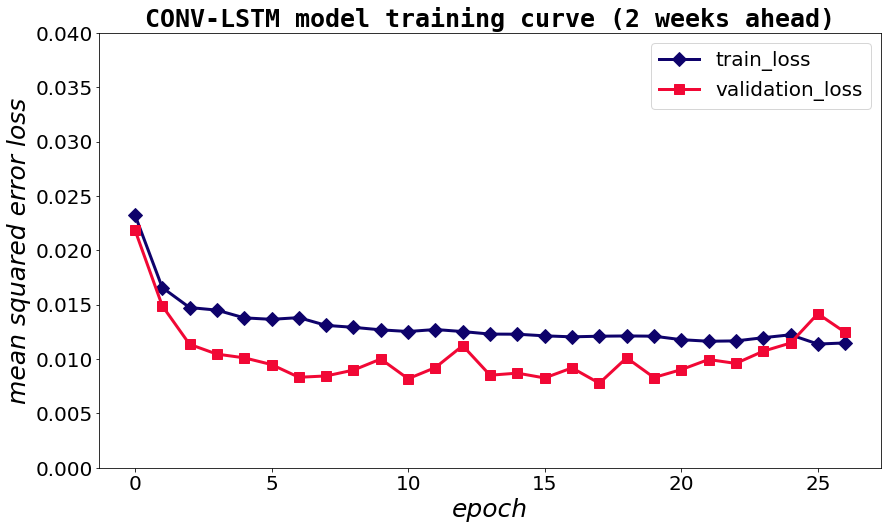

In [140]:
plt.figure(figsize=(14,8))

plt.plot(np.arange(len(conv_lstm_df2)-1), conv_lstm_df2['loss'][1:], label='train_loss', color='#0E026B', marker='D', lw=3, markersize=10)
plt.plot(np.arange(len(conv_lstm_df2)-1), conv_lstm_df2['val_loss'][:-1], label='validation_loss', color='#F10835', marker='s', lw=3, markersize=10)
plt.title('CONV-LSTM model training curve (2 weeks ahead)', fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.xlabel('epoch', style='italic', fontsize=25)
plt.ylabel('mean squared error loss', style='italic', fontsize=25)
plt.ylim([0,0.04])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

To see how well our model performed, we are going to plot our model predicitons with the test targets. However, before we can do that, we need to process our predictions and test target into a more suitable format

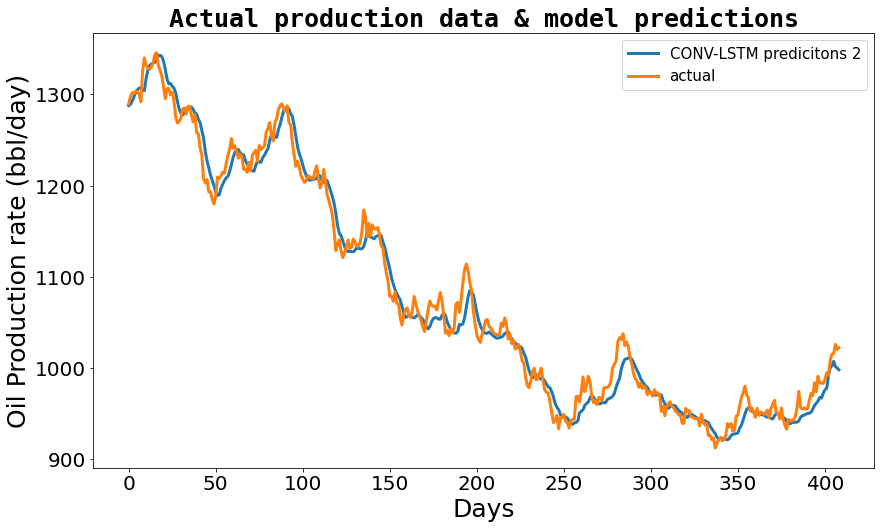

In [141]:
plt.figure(figsize=(14,8))

plt.plot(conv_lstm_predictions2, label='CONV-LSTM predicitons 2', lw=3)
plt.plot(actual_targets, label='actual', lw=3)
plt.title("Actual production data & model predictions", fontfamily='monospace', fontsize=25, weight='bold', color='k')
plt.ylabel('Oil Production rate (bbl/day)', fontsize=25)
plt.xlabel('Days', fontsize=25)
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()